In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

# Read the CSV file with specified column types
data = pd.read_csv(
    'data_2.csv',
    dtype={
        'Rate': 'float64',
        'Currency': 'string',
        'Maturity': 'string',
        'Year': 'int64'
    },
    parse_dates=['Date']  # Ensure 'Date' column is datetime
)

# Extract last 8 columns (swap rate maturities)
swap_rates = data.iloc[:, -8:]  # Only last 8 columns
currencies = data["Currency"]  # Currency column
dates = data["Date"]  # Date column

# Initialize empty lists for train and validation sets
train_data, val_data = [], []
train_dates, val_dates = [], []
train_currencies, val_currencies = [], []

# Perform train-validation split at the currency level
for currency in currencies.unique():
    currency_data = swap_rates[currencies == currency]  # Select rows for this currency
    currency_dates = dates[currencies == currency]  # Keep corresponding dates
    currency_labels = currencies[currencies == currency]  # Keep currency info

    # 90% train, 10% validation split
    train, val, train_date, val_date, train_curr, val_curr = train_test_split(
        currency_data, currency_dates, currency_labels, test_size=0.1, random_state=42
    )

    train_data.append(train)
    val_data.append(val)
    train_dates.append(train_date)
    val_dates.append(val_date)
    train_currencies.append(train_curr)
    val_currencies.append(val_curr)

# Combine back into DataFrames
train_df = pd.concat(train_data)
val_df = pd.concat(val_data)
train_dates_df = pd.concat(train_dates)
val_dates_df = pd.concat(val_dates)
train_currencies_df = pd.concat(train_currencies)
val_currencies_df = pd.concat(val_currencies)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_df.values, dtype=torch.float32)
val_tensor = torch.tensor(val_df.values, dtype=torch.float32)

# Convert dates and currencies to NumPy for easy indexing
train_dates_np = train_dates_df.to_numpy()
val_dates_np = val_dates_df.to_numpy()
train_currencies_np = train_currencies_df.to_numpy()
val_currencies_np = val_currencies_df.to_numpy()

# === SHUFFLE training data ===
train_indices = np.random.permutation(len(train_tensor))
train_tensor = train_tensor[train_indices]
train_dates_np = train_dates_np[train_indices]
train_currencies_np = train_currencies_np[train_indices]

# === SHUFFLE validation data ===
val_indices = np.random.permutation(len(val_tensor))
val_tensor = val_tensor[val_indices]
val_dates_np = val_dates_np[val_indices]
val_currencies_np = val_currencies_np[val_indices]

# Print tensor shapes for verification
print("Train Tensor Shape:", train_tensor.shape)
print("Validation Tensor Shape:", val_tensor.shape)

# Store tensors with their corresponding dates and currencies
train_data_with_dates_currencies = (train_tensor, train_dates_np, train_currencies_np)
val_data_with_dates_currencies = (val_tensor, val_dates_np, val_currencies_np)

Train Tensor Shape: torch.Size([1226, 8])
Validation Tensor Shape: torch.Size([140, 8])


In [4]:
train_currencies_np

array(['AUD', 'NOK', 'CAD', ..., 'JPY', 'SEK', 'USD'], dtype=object)

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

class CenteredSoftmax(nn.Module):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x)) - 0.5

# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=3, hidden_dim=10):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Linear(8, latent_dim, bias=False)  # No bias in encoder per AE2 model
        self.decoder_hidden = nn.Linear(latent_dim + 1, hidden_dim, bias=False)
        self.activation = CenteredSoftmax()  
        self.decoder_output = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, x):
        batch_size = x.shape[0]
        z = self.encoder(x)
        
        maturities = torch.arange(1, 31, dtype=torch.float32, device=x.device).repeat(batch_size, 1)
        z_repeated = z.unsqueeze(1).repeat(1, 30, 1)
        
        decoder_input = torch.cat([z_repeated, maturities.unsqueeze(-1)], dim=-1)
        hidden = self.activation(self.decoder_hidden(decoder_input))
        zero_coupon_rates = self.decoder_output(hidden).squeeze(-1)
        
        return zero_coupon_rates, z, maturities

# Convert zero-coupon rates to swap rates
def zero_coupon_to_swap_rates(zero_coupon_rates, maturities):
    discount_factors = torch.exp(-zero_coupon_rates * maturities)
    cumulative_sums = torch.tril(torch.ones(30, 30, device=zero_coupon_rates.device)) @ discount_factors.T
    cumulative_sums = cumulative_sums.T
    swap_rates = (1 - discount_factors) / cumulative_sums
    return swap_rates

# Set fixed parameters
initial_learning_rate = 0.01  # Initial LR
batch_size = 32
latent_dim = 3
hidden_dim = 10
epochs = 100

# Prepare data loaders
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=batch_size, shuffle=False)

# Initialize model, optimizer, and loss function
model = Autoencoder(latent_dim=latent_dim, hidden_dim=hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)

# Learning rate scheduler
def lr_lambda(epoch):
    return 0.9 ** (epoch // 50)  # Decays every 50 epochs
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

criterion = nn.MSELoss()
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_path = "best_autoencoder_model.pth"

# Training loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for X_batch in train_loader:
        optimizer.zero_grad()
        zero_coupon_rates, _, maturities = model(X_batch)
        swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)
        loss = criterion(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], X_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = (total_train_loss / len(train_loader)) ** 0.5
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch in val_loader:
            zero_coupon_rates, _, maturities = model(X_batch)
            swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)
            val_loss = criterion(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], X_batch)
            total_val_loss += val_loss.item()
    
    avg_val_loss = (total_val_loss / len(val_loader)) ** 0.5
    val_losses.append(avg_val_loss)

    # Update learning rate scheduler
    scheduler.step()

    # Save model if validation loss is best so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
            'train_loss': avg_train_loss,
            'latent_dim': latent_dim,
            'hidden_dim': hidden_dim,
        }, best_model_path)
    
    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Train RMSE: {avg_train_loss:.6f}, Val RMSE: {avg_val_loss:.6f}, LR: {scheduler.get_last_lr()[0]:.6f}")

Epoch 0, Train RMSE: 0.024339, Val RMSE: 0.011085, LR: 0.010000


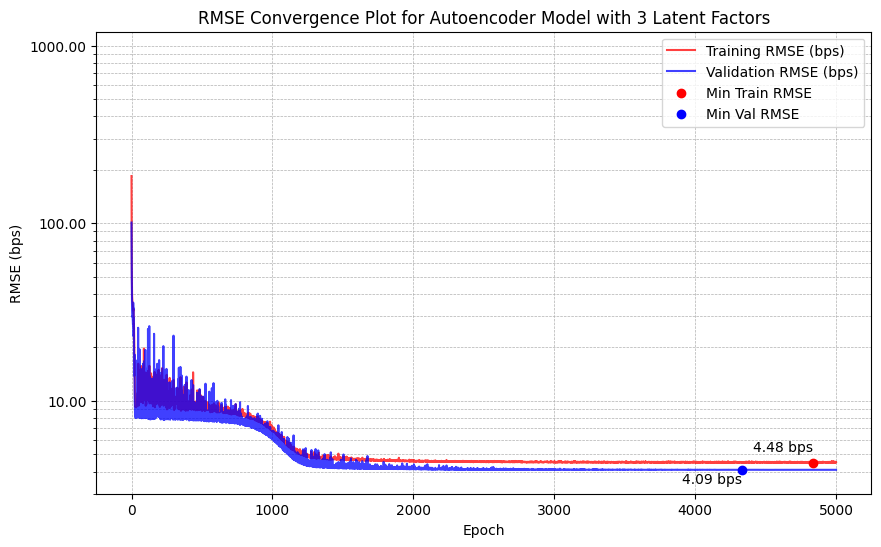

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Convert RMSE values to basis points (bps)
train_losses_bps = [loss * 10_000 for loss in train_losses]
val_losses_bps = [loss * 10_000 for loss in val_losses]

# Find min RMSE values in basis points and corresponding epochs
min_train_rmse_bps = min(train_losses_bps)
min_train_epoch = train_losses_bps.index(min_train_rmse_bps)

min_val_rmse_bps = min(val_losses_bps)
min_val_epoch = val_losses_bps.index(min_val_rmse_bps)

# Plot RMSE convergence
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses_bps, label='Training RMSE (bps)', alpha=0.75, color = "red")
plt.plot(range(epochs), val_losses_bps, label='Validation RMSE (bps)', alpha=0.75, color = "blue")

# Highlight min points
plt.scatter(min_train_epoch, min_train_rmse_bps, color='red', zorder=3, label='Min Train RMSE')
plt.scatter(min_val_epoch, min_val_rmse_bps, color='blue', zorder=3, label='Min Val RMSE')

# Annotate min points with their values in basis points
plt.text(min_train_epoch, min_train_rmse_bps + 0.5, f"{min_train_rmse_bps:.2f} bps", 
         verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

plt.text(min_val_epoch, min_val_rmse_bps - 0.8, f"{min_val_rmse_bps:.2f} bps", 
         verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

plt.xlabel('Epoch')
plt.ylabel('RMSE (bps)')
plt.yscale('log')  # Log-scale y-axis
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
plt.title('RMSE Convergence Plot for Autoencoder Model with 3 Latent Factors')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()

# Define shared y-axis ticks for log scale
shared_ticks = [10, 100, 1000]  # or whatever range makes sense for you

plt.yscale('log')
plt.ylim(3, 1200)  # Or your chosen limits
plt.yticks(shared_ticks)
plt.gca().set_yticklabels([f"{tick:.2f}" for tick in shared_ticks])  # Format if needed
plt.show()

In [8]:
import pandas as pd
import torch
import torch.nn as nn

# Load full data (already wide format)
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])

# Filter for test data from 2023 and 2024
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()

# Define function to compute RMSE
def compute_rmse(model, data_tensor):
    model.eval()
    with torch.no_grad():
        zero_coupon_rates, _, maturities = model(data_tensor)
        swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)
        mse_loss = nn.MSELoss()(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], data_tensor)
        return mse_loss.sqrt().item()

# Compute RMSE for each currency
currency_rmse = []

for currency in currencies.unique():
    currency_train_tensor = torch.tensor(
        train_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_val_tensor = torch.tensor(
        val_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_test_tensor = torch.tensor(
        test_df[test_df['Currency'] == currency].iloc[:, 2:].values, dtype=torch.float32
    )

    train_rmse = compute_rmse(model, currency_train_tensor) * 10_000
    val_rmse = compute_rmse(model, currency_val_tensor) * 10_000
    test_rmse = compute_rmse(model, currency_test_tensor) * 10_000

    currency_rmse.append({
        "Currency": currency,
        "Train RMSE (bps)": train_rmse,
        "Validation RMSE (bps)": val_rmse,
        "Test RMSE (bps)": test_rmse
    })

# Create DataFrame and add average row
rmse_df = pd.DataFrame(currency_rmse)
rmse_df.loc[len(rmse_df)] = [
    "Average",
    rmse_df["Train RMSE (bps)"].mean(),
    rmse_df["Validation RMSE (bps)"].mean(),
    rmse_df["Test RMSE (bps)"].mean()
]

# Print RMSE table
print(rmse_df.to_string(index=False))

Currency  Train RMSE (bps)  Validation RMSE (bps)  Test RMSE (bps)
     AUD          4.917541               4.028153         5.045459
     CAD          4.151773               4.695926         6.158174
     DKK          4.697769               2.744386         6.606139
     EUR          4.551894               3.995562         7.176896
     GBP          3.281688               3.466199              NaN
     JPY          5.265491               5.044049         3.504992
     NOK          4.479686               3.873191         9.766528
     SEK          4.080463               3.706258         5.446401
     USD          4.681901               3.874531         5.568798
 Average          4.456467               3.936473         6.159173


In [8]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np

# Load and filter test data
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()

# Updated function: return per-curve RMSEs
def compute_rmse_and_std(model, data_tensor):
    model.eval()
    with torch.no_grad():
        zero_coupon_rates, _, maturities = model(data_tensor)
        swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)
        
        # ✅ Standard RMSE (same as before)
        mse_loss = nn.MSELoss()(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], data_tensor)
        rmse = mse_loss.sqrt().item()

        # ✅ Per-curve RMSEs for std
        per_curve_mse = torch.mean((swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]] - data_tensor) ** 2, dim=1)
        per_curve_rmse = torch.sqrt(per_curve_mse)
        std = per_curve_rmse.std().item()

        return rmse * 10_000, std * 10_000  # Convert to bps

# Compute RMSE + STD for each currency
currency_rmse = []

for currency in currencies.unique():
    currency_train_tensor = torch.tensor(
        train_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_val_tensor = torch.tensor(
        val_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_test_tensor = torch.tensor(
        test_df[test_df['Currency'] == currency].iloc[:, 2:].values, dtype=torch.float32
    )

    train_rmse, train_std = compute_rmse_and_std(model, currency_train_tensor)
    val_rmse, val_std = compute_rmse_and_std(model, currency_val_tensor)
    test_rmse, test_std = compute_rmse_and_std(model, currency_test_tensor)

    currency_rmse.append({
        "Currency": currency,
        "Train RMSE (bps)": train_rmse,
        "Train STD (bps)": train_std,
        "Validation RMSE (bps)": val_rmse,
        "Validation STD (bps)": val_std,
        "Test RMSE (bps)": test_rmse,
        "Test STD (bps)": test_std
    })

# Convert to DataFrame and add average row
rmse_df = pd.DataFrame(currency_rmse)
rmse_df.loc[len(rmse_df)] = [
    "Average",
    rmse_df["Train RMSE (bps)"].mean(),
    rmse_df["Train STD (bps)"].mean(),
    rmse_df["Validation RMSE (bps)"].mean(),
    rmse_df["Validation STD (bps)"].mean(),
    rmse_df["Test RMSE (bps)"].mean(),
    rmse_df["Test STD (bps)"].mean()
]

# Print nicely
print(rmse_df.to_string(index=False))

Currency  Train RMSE (bps)  Train STD (bps)  Validation RMSE (bps)  Validation STD (bps)  Test RMSE (bps)  Test STD (bps)
     AUD          4.550512         2.044775               3.941827              1.132743         4.374144        1.302506
     CAD          4.108338         1.870759               4.427572              2.631509         5.445039        1.776719
     DKK          4.530581         2.475965               2.802990              1.467587         5.694486        1.601853
     EUR          4.362474         2.545060               3.959812              1.798993         6.226585        1.618679
     GBP          3.083661         1.414898               3.332151              1.306349              NaN             NaN
     JPY          5.292759         2.567335               5.024696              2.587668         3.426278        1.423907
     NOK          4.237911         1.825875               3.843530              1.496777         8.838325        1.848860
     SEK          3.8163

/var/folders/mh/j3zy8xqx2v32dk0tv4nx5x8m0000gn/T/ipykernel_835/4206458122.py:24: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  std = per_curve_rmse.std().item()


In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

# Prepare 8 observed maturity positions
maturity_labels = [1, 2, 3, 5, 10, 15, 20, 30]
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]

# Function to compute RMSE per maturity for a given tensor
def compute_rmse_per_maturity(model, data_tensor):
    model.eval()
    with torch.no_grad():
        zero_coupon_rates, _, maturities = model(data_tensor)
        swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)
        swap_rates_selected = swap_rates[:, selected_indices]

        mse_per_maturity = torch.mean((swap_rates_selected - data_tensor) ** 2, dim=0)
        rmse_per_maturity = torch.sqrt(mse_per_maturity) * 10_000  # Convert to bps
        return rmse_per_maturity.cpu().numpy()

# Compute per-maturity RMSEs
rmse_train = compute_rmse_per_maturity(model, train_tensor)
rmse_val   = compute_rmse_per_maturity(model, val_tensor)

# Prepare test data
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()
test_tensor = torch.tensor(test_df.iloc[:, 2:].values, dtype=torch.float32)
rmse_test = compute_rmse_per_maturity(model, test_tensor)

# Create DataFrame
rmse_by_maturity = pd.DataFrame({
    "Maturity (Years)": maturity_labels,
    "Train RMSE (bps)": rmse_train,
    "Validation RMSE (bps)": rmse_val,
    "Test RMSE (bps)": rmse_test
})

rmse_by_maturity


,Maturity (Years),Train RMSE (bps),Validation RMSE (bps),Test RMSE (bps)
0,1,3.507775,3.109115,4.674325
1,2,3.921057,3.205578,5.940821
2,3,3.634503,3.367145,4.926540
3,5,3.027248,2.500785,3.701409
4,10,5.159347,5.063130,5.373830
5,15,4.523687,4.145789,6.309585
6,20,2.845557,2.574479,4.088475
7,30,6.578736,5.865086,8.692803


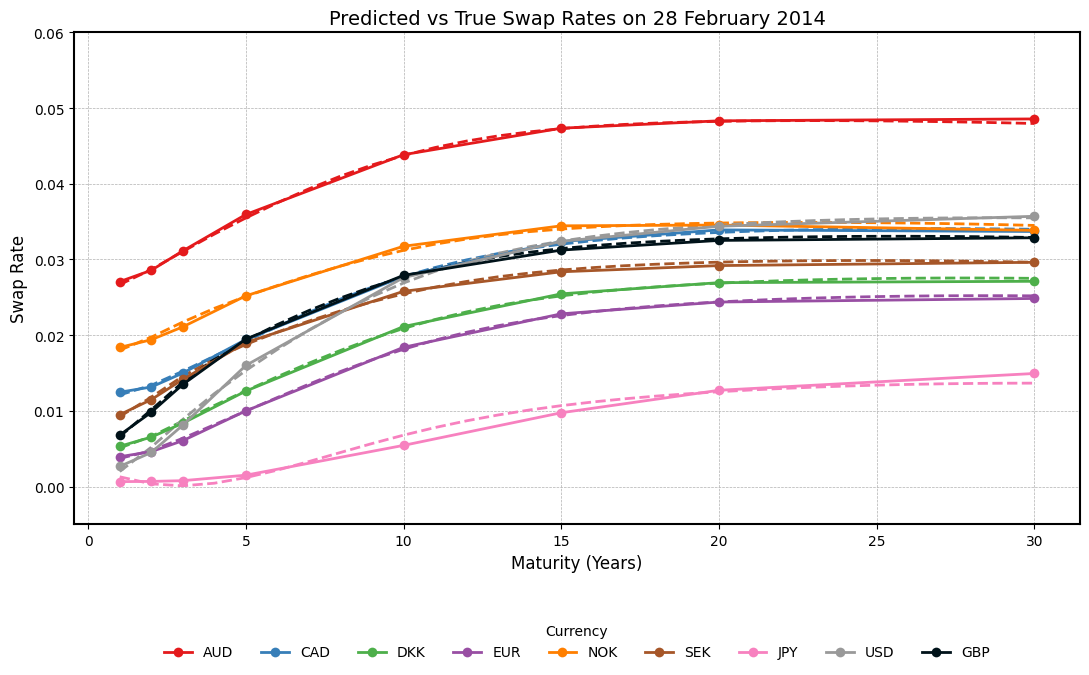

In [10]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Unpack train and validation tensors, dates, and currencies
train_tensor, train_dates_np, train_currencies_np = train_data_with_dates_currencies
val_tensor, val_dates_np, val_currencies_np = val_data_with_dates_currencies

# Filter for target date
target_date = np.datetime64("2014-02-28")
date_filter_train = train_dates_np == target_date
date_filter_val = val_dates_np == target_date

selected_train_data = train_tensor[date_filter_train]
selected_val_data = val_tensor[date_filter_val]

selected_train_currencies = train_currencies_np[date_filter_train]
selected_val_currencies = val_currencies_np[date_filter_val]

# Combine data
selected_data = torch.cat((selected_train_data, selected_val_data), dim=0)
selected_currencies = np.concatenate((selected_train_currencies, selected_val_currencies))

# Get predictions
model.eval()
with torch.no_grad():
    zero_coupon_rates_pred, _, maturities = model(selected_data)
    swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_rates_pred, maturities).cpu().numpy()

# Define maturities
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

# --- Build long-format DataFrame ---
plot_data = []
for i, currency in enumerate(selected_currencies):
    true_row = selected_data[i].cpu().numpy()
    pred_row = swap_rates_pred[i]

    for m_idx, m in enumerate(selected_maturities):
        plot_data.append({"Maturity": m, "Rate": true_row[m_idx], "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1], "Currency": currency, "Type": "Predicted"})

df_plot = pd.DataFrame(plot_data)

# --- Set desired currency order and colors ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219" 
}

# --- Plot ---
plt.figure(figsize=(11, 7))

# Predicted (dashed lines)
sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle="--",
    legend=False
)

# True (solid lines with filled markers)
true_lines = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

# Customize true markers (bigger + filled)
for line in true_lines.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)
        line.set_markerfacecolor(line.get_color())
        line.set_markeredgewidth(0)

# Axis styling
plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

plt.title("Predicted vs True Swap Rates on 28 February 2014", fontsize=14, ha="center")
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Swap Rate", fontsize=12)

# Legend
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

# Grid and border styling
plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

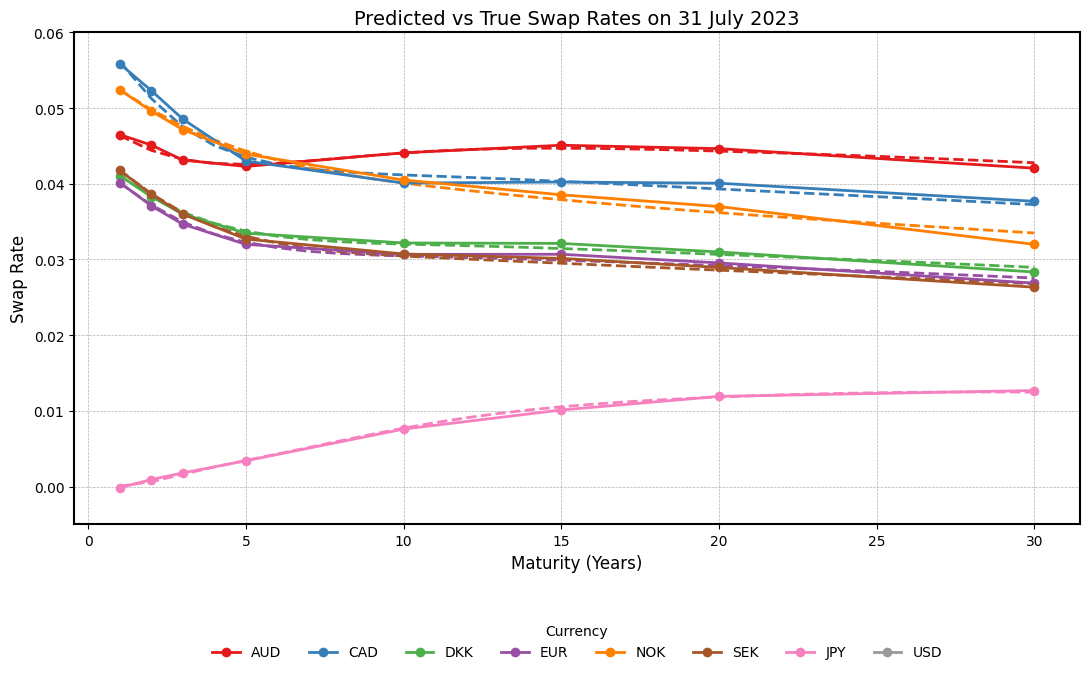

In [11]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load and filter data ---
plot_date = pd.to_datetime("2023-07-31")
data_full["Date"] = pd.to_datetime(data_full["Date"])
filtered_data = data_full[data_full["Date"] == plot_date].copy()

# Extract input swap rates and metadata
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
filtered_data_tensor = torch.tensor(filtered_data[maturity_cols].values, dtype=torch.float32)
filtered_currencies = filtered_data["Currency"].values

# --- Model predictions ---
model.eval()
with torch.no_grad():
    zero_coupon_pred, _, maturities = model(filtered_data_tensor)
    predicted_swaps = zero_coupon_to_swap_rates(zero_coupon_pred, maturities).cpu().numpy()

# --- Build long-form DataFrame ---
plot_data = []
for i, currency in enumerate(filtered_currencies):
    true_row = filtered_data_tensor[i].numpy()
    pred_row = predicted_swaps[i]
    for m_idx, (maturity, true_rate) in enumerate(zip(maturity_cols, true_row)):
        plot_data.append({"Maturity": int(maturity.rstrip("Y")), "Rate": true_rate, "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1], "Currency": currency, "Type": "Predicted"})

df_plot = pd.DataFrame(plot_data)

# --- Define custom order and palette ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD']
custom_palette = {
    'AUD': "#E41A1C",
    'CAD': "#377EB8",
    'DKK': "#4DAF4A",
    'EUR': "#984EA3",
    'NOK': "#FF7F00",
    'SEK': "#A65628",
    'JPY': "#F781BF",
    'USD': "#999999"
}

# --- Plot ---
plt.figure(figsize=(11, 7))

# Predicted curves
sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle='--',
    legend=False
)

# Plot true swap rates (with larger, filled markers)
lineplot = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

# --- Remove white border & increase marker size ---
for line in lineplot.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)                     # Increase size
        line.set_markerfacecolor(line.get_color()) # Fill with line color
        line.set_markeredgewidth(0)                # Remove border


# Axis formatting
plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

# Labels and title
plt.title("Predicted vs True Swap Rates on 31 July 2023", fontsize=14, ha="center")
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Swap Rate", fontsize=12)

# Custom legend with desired order
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=8,
    frameon=False
)

# Grid and styling
plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

In [12]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd

# Combine train and validation datasets into one dataset
data_tensor = torch.cat((train_tensor, val_tensor), dim=0)
data_currencies_np = np.concatenate((train_currencies_np, val_currencies_np))

# Define function for leave-one-currency-out cross-validation
def leave_one_currency_out_cv(model, data_tensor, data_currencies_np):
    unique_currencies = np.unique(data_currencies_np)
    results = []
    
    for left_out_currency in unique_currencies:
        print(f"Leaving out: {left_out_currency}")
        
        # Split data into training and test sets
        train_mask = data_currencies_np != left_out_currency
        test_mask = data_currencies_np == left_out_currency
        
        train_data = data_tensor[train_mask]
        test_data = data_tensor[test_mask]
        
        # Train model on training data
        model.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.9 ** (epoch // 50))
        criterion = torch.nn.MSELoss()
        
        for epoch in range(5000):  # Small number of epochs for demonstration
            optimizer.zero_grad()
            zero_coupon_rates_pred, _, maturities = model(train_data)
            swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_rates_pred, maturities)
            loss = criterion(swap_rates_pred[:, [0, 1, 2, 4, 9, 14, 19, 29]], train_data)
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        # Evaluate model on test and train data
        model.eval()
        with torch.no_grad():
            # RMSE for unseen currency (test set)
            zero_coupon_rates_pred_test, _, maturities = model(test_data)
            swap_rates_pred_test = zero_coupon_to_swap_rates(zero_coupon_rates_pred_test, maturities)
            rmse_unseen = torch.sqrt(criterion(swap_rates_pred_test[:, [0, 1, 2, 4, 9, 14, 19, 29]], test_data)).item() * 10_000  # Convert to basis points
            
            # RMSE for seen currencies (train set)
            zero_coupon_rates_pred_train, _, maturities = model(train_data)
            swap_rates_pred_train = zero_coupon_to_swap_rates(zero_coupon_rates_pred_train, maturities)
            rmse_seen = torch.sqrt(criterion(swap_rates_pred_train[:, [0, 1, 2, 4, 9, 14, 19, 29]], train_data)).item() * 10_000  # Convert to basis points
        
        results.append({"Currency Left Out": left_out_currency, "RMSE Unseen (bps)": rmse_unseen, "RMSE Seen (bps)": rmse_seen})
    
    return results

# Run leave-one-currency-out cross-validation
cv_results = leave_one_currency_out_cv(model, data_tensor, data_currencies_np)

# Print results
cv_results_df = pd.DataFrame(cv_results)
print(cv_results_df.to_string(index=False))


Leaving out: AUD
Leaving out: CAD
Leaving out: DKK
Leaving out: EUR
Leaving out: GBP
Leaving out: JPY
Leaving out: NOK
Leaving out: SEK
Leaving out: USD
Currency Left Out  RMSE Unseen (bps)  RMSE Seen (bps)
              AUD           4.771492         4.307243
              CAD           4.290196         4.373520
              DKK           4.717638         4.386776
              EUR           4.580272         4.473400
              GBP           3.505821         4.606551
              JPY           6.714776         4.283151
              NOK           4.515111         4.644371
              SEK           3.914399         4.672164
              USD           4.292159         4.694464


In [13]:
cv_results_df.loc["Average"] = ["Average", cv_results_df["RMSE Unseen (bps)"].mean(), cv_results_df["RMSE Seen (bps)"].mean()]

# Print results
print(cv_results_df.to_string(index=False))

Currency Left Out  RMSE Unseen (bps)  RMSE Seen (bps)
              AUD           4.771492         4.307243
              CAD           4.290196         4.373520
              DKK           4.717638         4.386776
              EUR           4.580272         4.473400
              GBP           3.505821         4.606551
              JPY           6.714776         4.283151
              NOK           4.515111         4.644371
              SEK           3.914399         4.672164
              USD           4.292159         4.694464
          Average           4.589096         4.493516


Worst RMSE date: 2022-03-31T00:00:00.000000000, RMSE: 0.0010


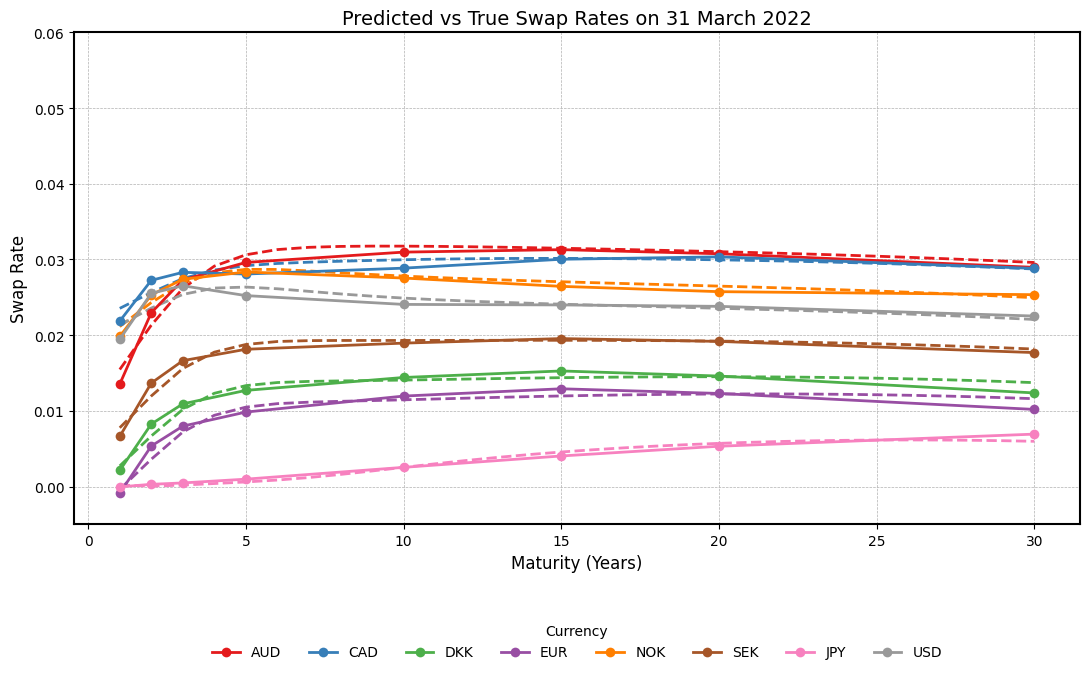

In [18]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Define maturities
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

# Step 1: Find the date with the highest average per-curve RMSE in train + val
def get_rmse_by_date(tensor, dates_np):
    unique_dates = np.unique(dates_np)
    date_rmse = {}
    model.eval()
    with torch.no_grad():
        for date in unique_dates:
            mask = dates_np == date
            if mask.sum() == 0:
                continue
            data = tensor[mask]
            zero_coupon, _, maturities = model(data)
            swap_rates = zero_coupon_to_swap_rates(zero_coupon, maturities)
            swap_sel = swap_rates[:, selected_indices]
            rmse_per_curve = torch.sqrt(torch.mean((swap_sel - data) ** 2, dim=1))
            date_rmse[date] = rmse_per_curve.mean().item()
    return date_rmse

# Compute RMSEs for training and validation
train_rmse_by_date = get_rmse_by_date(train_tensor, train_dates_np)
val_rmse_by_date = get_rmse_by_date(val_tensor, val_dates_np)

# Combine and find date with highest RMSE
all_rmse_by_date = {**train_rmse_by_date, **val_rmse_by_date}
worst_date = max(all_rmse_by_date, key=all_rmse_by_date.get)
print(f"Worst RMSE date: {worst_date}, RMSE: {all_rmse_by_date[worst_date]:.4f}")

# Step 2: Filter data for that date
train_mask = train_dates_np == worst_date
val_mask = val_dates_np == worst_date
selected_data = torch.cat((train_tensor[train_mask], val_tensor[val_mask]), dim=0)
selected_currencies = np.concatenate((train_currencies_np[train_mask], val_currencies_np[val_mask]))

# Step 3: Predict
model.eval()
with torch.no_grad():
    zero_coupon_pred, _, maturities = model(selected_data)
    swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_pred, maturities).cpu().numpy()

# Step 4: Build long-format DataFrame
plot_data = []
for i, currency in enumerate(selected_currencies):
    true_row = selected_data[i].cpu().numpy()
    pred_row = swap_rates_pred[i]
    for m_idx, m in enumerate(selected_maturities):
        plot_data.append({"Maturity": m, "Rate": true_row[m_idx], "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1], "Currency": currency, "Type": "Predicted"})
df_plot = pd.DataFrame(plot_data)

# Step 5: Plot
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD']
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999"
}

plt.figure(figsize=(11, 7))

# Predicted
sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle="--",
    legend=False
)

# True
true_lines = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

# Format markers
for line in true_lines.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)
        line.set_markerfacecolor(line.get_color())
        line.set_markeredgewidth(0)

# Axis
plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

plt.title(f"Predicted vs True Swap Rates on {pd.to_datetime(worst_date).strftime('%d %B %Y')}", fontsize=14)
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Swap Rate", fontsize=12)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

Worst test RMSE date: 2023-12-29 00:00:00, RMSE: 0.0008


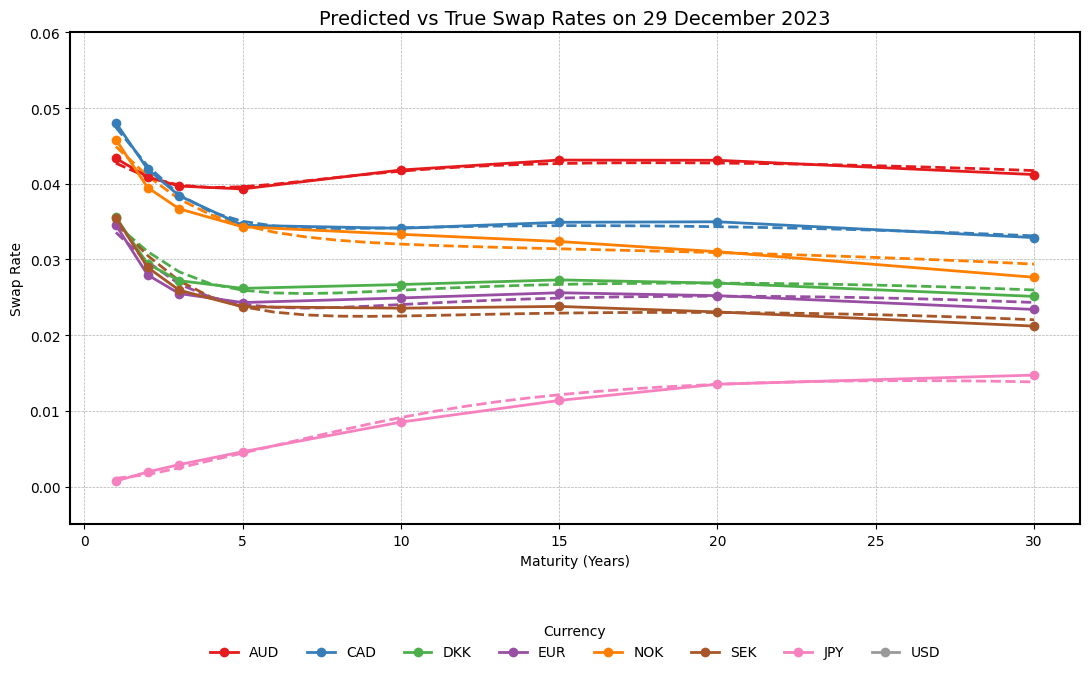

In [17]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Define maturities
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

# Load test data
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()

# Step 1: Compute RMSE per date
def get_test_rmse_by_date(model, test_df):
    unique_dates = test_df['Date'].unique()
    date_rmse = {}
    model.eval()
    with torch.no_grad():
        for date in unique_dates:
            day_df = test_df[test_df['Date'] == date]
            if day_df.empty:
                continue
            data_tensor = torch.tensor(day_df.iloc[:, 2:].values, dtype=torch.float32)
            zero_coupon, _, maturities = model(data_tensor)
            swap_rates = zero_coupon_to_swap_rates(zero_coupon, maturities)
            swap_sel = swap_rates[:, selected_indices]
            rmse_per_curve = torch.sqrt(torch.mean((swap_sel - data_tensor) ** 2, dim=1))
            date_rmse[date] = rmse_per_curve.mean().item()
    return date_rmse

# Run and find worst date
test_rmse_by_date = get_test_rmse_by_date(model, test_df)
worst_test_date = max(test_rmse_by_date, key=test_rmse_by_date.get)
print(f"Worst test RMSE date: {worst_test_date}, RMSE: {test_rmse_by_date[worst_test_date]:.4f}")

# Step 2: Prepare data for plotting
worst_day_df = test_df[test_df['Date'] == worst_test_date]
true_tensor = torch.tensor(worst_day_df.iloc[:, 2:].values, dtype=torch.float32)
currencies = worst_day_df['Currency'].values

# Predict
model.eval()
with torch.no_grad():
    zero_coupon_pred, _, maturities = model(true_tensor)
    swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_pred, maturities).cpu().numpy()

# Step 3: Build plot DataFrame
plot_data = []
for i, currency in enumerate(currencies):
    true_row = true_tensor[i].cpu().numpy()
    pred_row = swap_rates_pred[i]
    for m_idx, m in enumerate(selected_maturities):
        plot_data.append({"Maturity": m, "Rate": true_row[m_idx], "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1], "Currency": currency, "Type": "Predicted"})
df_plot = pd.DataFrame(plot_data)

# Step 4: Plot
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD']
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999"
}

plt.figure(figsize=(11, 7))

# Predicted
sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle="--",
    legend=False
)

# True
true_lines = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

# Format true markers
for line in true_lines.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)
        line.set_markerfacecolor(line.get_color())
        line.set_markeredgewidth(0)

plt.title(f"Predicted vs True Swap Rates on {pd.to_datetime(worst_test_date).strftime('%d %B %Y')}", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

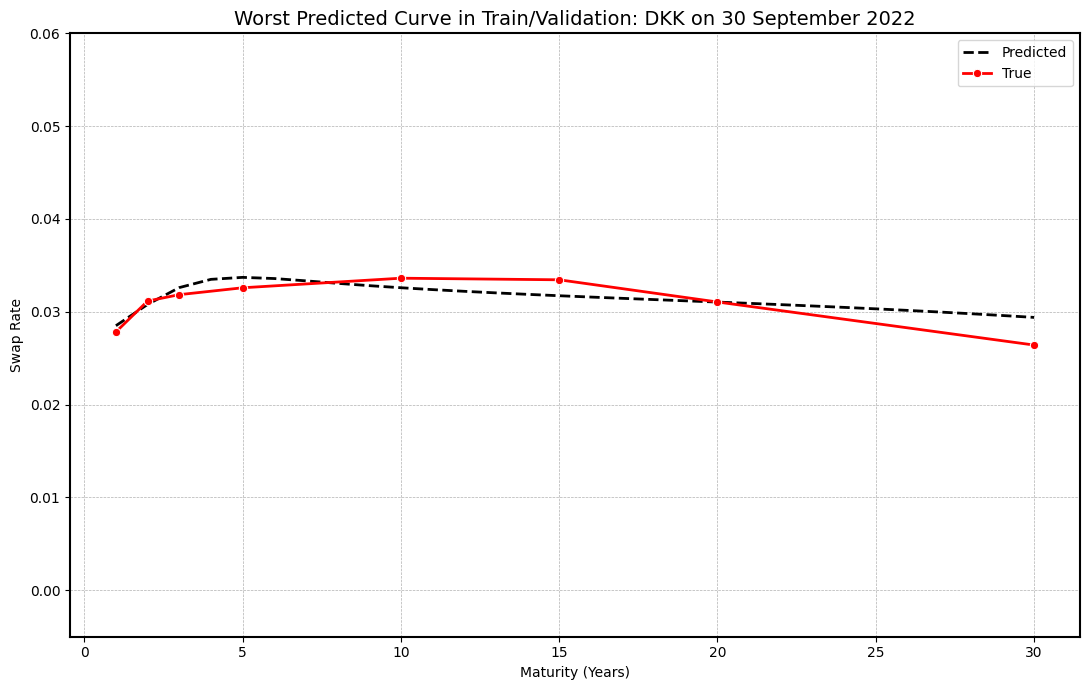

In [20]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Maturity setup
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

# Combine train and validation sets
train_val_tensor = torch.cat((train_tensor, val_tensor), dim=0)
train_val_dates = np.concatenate((train_dates_np, val_dates_np))
train_val_currencies = np.concatenate((train_currencies_np, val_currencies_np))

# Get model predictions
model.eval()
with torch.no_grad():
    zero_coupon_pred, _, maturities = model(train_val_tensor)
    swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_pred, maturities)
    selected_pred = swap_rates_pred[:, selected_indices]

    # Compute RMSE per curve
    rmse_per_curve = torch.sqrt(torch.mean((selected_pred - train_val_tensor) ** 2, dim=1))
    worst_idx = torch.argmax(rmse_per_curve).item()

# Extract worst-case curve info
true_curve = train_val_tensor[worst_idx].numpy()
pred_curve = swap_rates_pred[worst_idx].cpu().numpy()
currency = train_val_currencies[worst_idx]
date = pd.to_datetime(train_val_dates[worst_idx])

# Prepare long-form plot data
plot_data = []
for m_idx, m in enumerate(selected_maturities):
    plot_data.append({"Maturity": m, "Rate": true_curve[m_idx], "Type": "True"})
for m in full_maturities:
    plot_data.append({"Maturity": m, "Rate": pred_curve[m-1], "Type": "Predicted"})
df_plot = pd.DataFrame(plot_data)

# Plot
plt.figure(figsize=(11, 7))
sns.lineplot(data=df_plot[df_plot["Type"] == "Predicted"],
             x="Maturity", y="Rate", color="black", linestyle="--", linewidth=2, label="Predicted")
sns.lineplot(data=df_plot[df_plot["Type"] == "True"],
             x="Maturity", y="Rate", color="red", marker='o', linewidth=2, label="True")

plt.title(f"Worst Predicted Curve in Train/Validation: {currency} on {date.strftime('%d %B %Y')}", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)
plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
plt.legend()
plt.tight_layout()
plt.show()

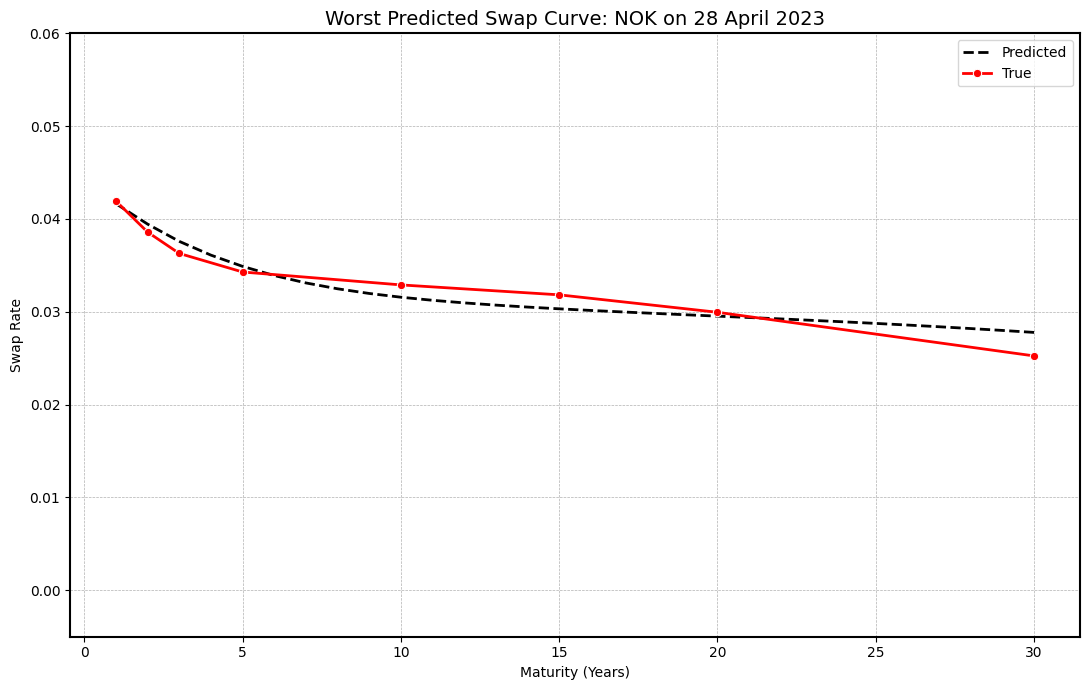

In [19]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Define maturities
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

# Load test data
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()

# Convert to tensor
test_tensor = torch.tensor(test_df.iloc[:, 2:].values, dtype=torch.float32)
test_dates = test_df["Date"].values
test_currencies = test_df["Currency"].values

# Get predictions
model.eval()
with torch.no_grad():
    zero_coupon_pred, _, maturities = model(test_tensor)
    swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_pred, maturities)
    selected_pred = swap_rates_pred[:, selected_indices]

    # RMSE for each curve
    rmse_per_curve = torch.sqrt(torch.mean((selected_pred - test_tensor) ** 2, dim=1))
    worst_idx = torch.argmax(rmse_per_curve).item()

# Extract true/pred for worst curve
true_curve = test_tensor[worst_idx].numpy()
pred_curve = swap_rates_pred[worst_idx].cpu().numpy()
currency = test_currencies[worst_idx]
date = pd.to_datetime(test_dates[worst_idx])

# Prepare plot data
plot_data = []
for m_idx, m in enumerate(selected_maturities):
    plot_data.append({"Maturity": m, "Rate": true_curve[m_idx], "Type": "True"})
for m in full_maturities:
    plot_data.append({"Maturity": m, "Rate": pred_curve[m-1], "Type": "Predicted"})
df_plot = pd.DataFrame(plot_data)

# Plot
plt.figure(figsize=(11, 7))
sns.lineplot(data=df_plot[df_plot["Type"] == "Predicted"],
             x="Maturity", y="Rate", color="black", linestyle="--", linewidth=2, label="Predicted")
sns.lineplot(data=df_plot[df_plot["Type"] == "True"],
             x="Maturity", y="Rate", color="red", marker='o', linewidth=2, label="True")

plt.title(f"Worst Predicted Swap Curve: {currency} on {date.strftime('%d %B %Y')}", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)
plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/mh/j3zy8xqx2v32dk0tv4nx5x8m0000gn/T/ipykernel_835/3972921082.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_cycle = plt.cm.get_cmap('tab10', 10)


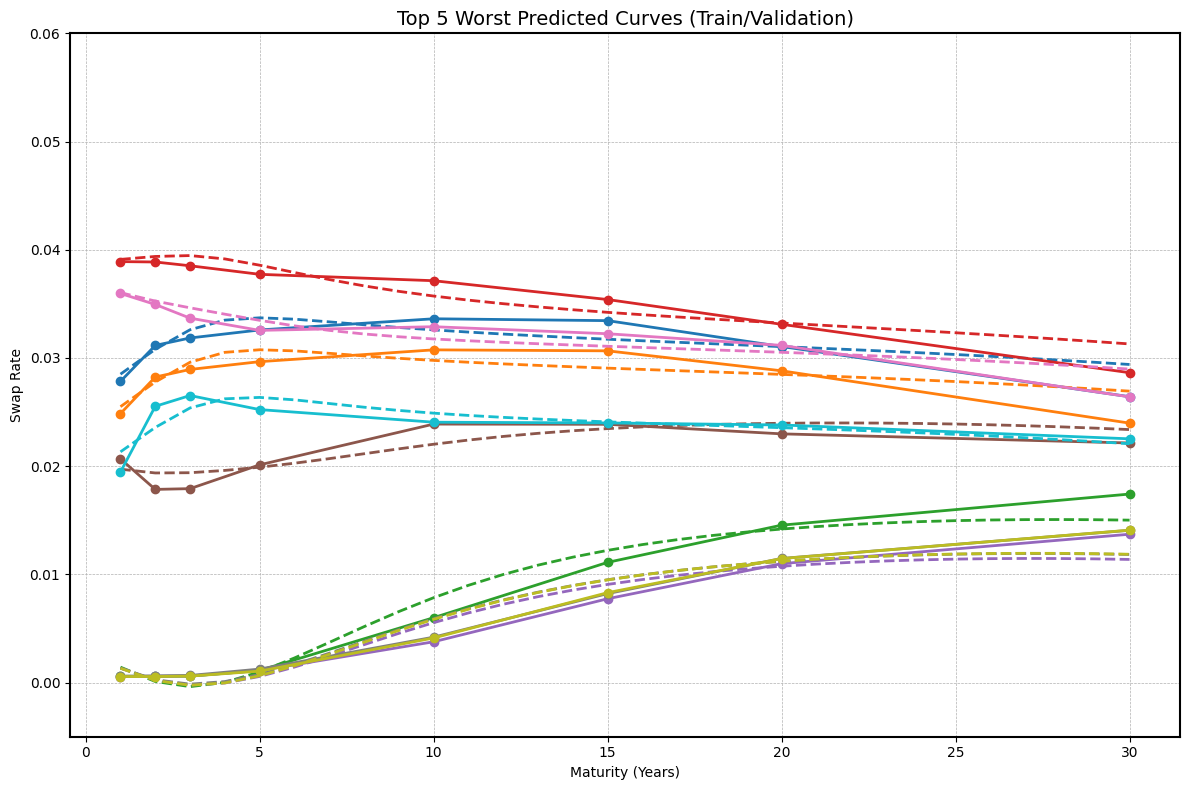

In [24]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# Maturity setup
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

# Combine train and validation sets
train_val_tensor = torch.cat((train_tensor, val_tensor), dim=0)
train_val_dates = np.concatenate((train_dates_np, val_dates_np))
train_val_currencies = np.concatenate((train_currencies_np, val_currencies_np))

# Predict and compute per-curve RMSE
model.eval()
with torch.no_grad():
    zero_coupon_pred, _, maturities = model(train_val_tensor)
    swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_pred, maturities)
    selected_pred = swap_rates_pred[:, selected_indices]
    rmse_per_curve = torch.sqrt(torch.mean((selected_pred - train_val_tensor) ** 2, dim=1))

# Get top 5 worst curves
worst_indices = torch.topk(rmse_per_curve, 10).indices.cpu().numpy()
color_cycle = plt.cm.get_cmap('tab10', 10)

# Plot
plt.figure(figsize=(12, 8))

for i, idx in enumerate(worst_indices):
    color = color_cycle(i)
    true_curve = train_val_tensor[idx].numpy()
    pred_curve = swap_rates_pred[idx].cpu().numpy()
    currency = train_val_currencies[idx]
    date = pd.to_datetime(train_val_dates[idx]).strftime('%Y-%m-%d')
    label = f"{currency} ({date})"

    # Predicted curve (dashed)
    plt.plot(full_maturities, pred_curve, linestyle="--", linewidth=2, color=color, label=f"Predicted - {label}")

    # True curve (solid + dots)
    plt.plot(selected_maturities, true_curve, marker='o', linewidth=2, color=color, label=f"True - {label}")

# Format
plt.title("Top 5 Worst Predicted Curves (Train/Validation)", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(range(0, 31, 5))
plt.yticks(np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)
plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

#plt.legend(loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()

/var/folders/mh/j3zy8xqx2v32dk0tv4nx5x8m0000gn/T/ipykernel_835/3132801894.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_cycle = plt.cm.get_cmap("tab10", 10)


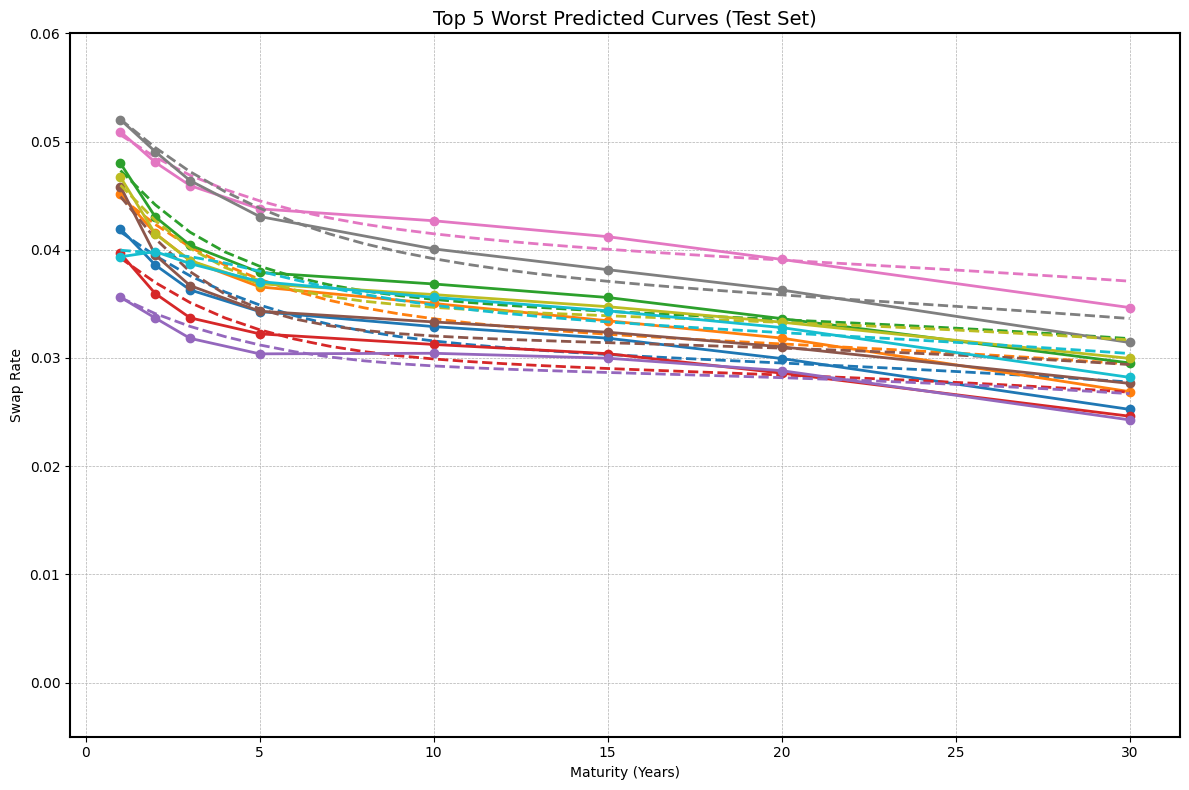

In [25]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# Maturity info
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

# Load test data
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
test_df = data_full[data_full["Date"].dt.year.isin([2023, 2024])].copy()

# Convert to tensors
test_tensor = torch.tensor(test_df.iloc[:, 2:].values, dtype=torch.float32)
test_currencies = test_df["Currency"].values
test_dates = test_df["Date"].values

# Predict and compute per-curve RMSE
model.eval()
with torch.no_grad():
    zero_coupon_pred, _, maturities = model(test_tensor)
    swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_pred, maturities)
    selected_pred = swap_rates_pred[:, selected_indices]
    rmse_per_curve = torch.sqrt(torch.mean((selected_pred - test_tensor) ** 2, dim=1))

# Get top 5 worst curves
worst_indices = torch.topk(rmse_per_curve, 10).indices.cpu().numpy()
color_cycle = plt.cm.get_cmap("tab10", 10)

# Plot setup
plt.figure(figsize=(12, 8))

for i, idx in enumerate(worst_indices):
    color = color_cycle(i)
    true_curve = test_tensor[idx].numpy()
    pred_curve = swap_rates_pred[idx].cpu().numpy()
    currency = test_currencies[idx]
    date = pd.to_datetime(test_dates[idx]).strftime("%Y-%m-%d")
    label = f"{currency} ({date})"

    # Plot predicted curve (dashed)
    plt.plot(full_maturities, pred_curve, linestyle="--", linewidth=2, color=color, label=f"Predicted - {label}")

    # Plot true curve (solid + dots)
    plt.plot(selected_maturities, true_curve, marker="o", linewidth=2, color=color, label=f"True - {label}")

# Format
plt.title("Top 5 Worst Predicted Curves (Test Set)", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(range(0, 31, 5))
plt.yticks(np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)
plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

#plt.legend(loc="upper right", fontsize=9)
plt.tight_layout()
plt.show()

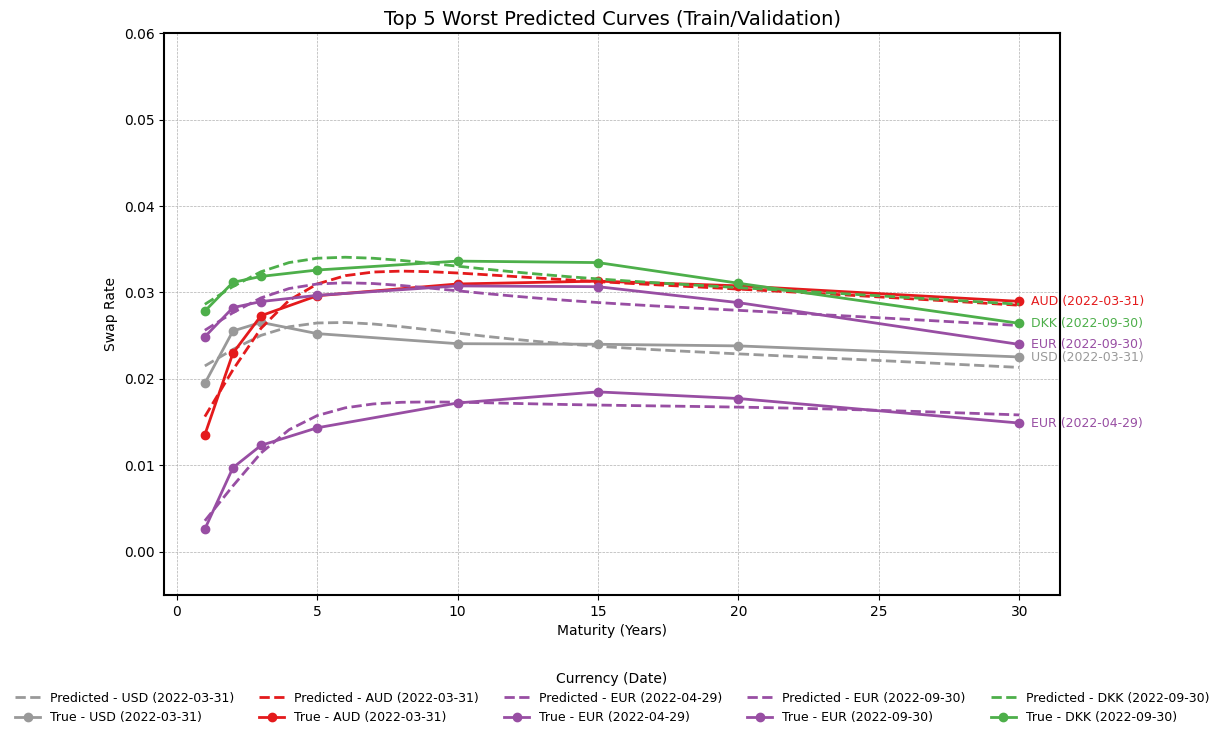

In [9]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# Define distinct marker styles
marker_styles = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>']

# --- Setup ---
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}
fallback_color = "#000000"

# Combine train + validation
train_val_tensor = torch.cat((train_tensor, val_tensor), dim=0)
train_val_dates = np.concatenate((train_dates_np, val_dates_np))
train_val_currencies = np.concatenate((train_currencies_np, val_currencies_np))

# --- Model Prediction ---
model.eval()
with torch.no_grad():
    zero_coupon_pred, _, maturities = model(train_val_tensor)
    swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_pred, maturities)
    selected_pred = swap_rates_pred[:, selected_indices]
    rmse_per_curve = torch.sqrt(torch.mean((selected_pred - train_val_tensor) ** 2, dim=1))

# --- Top 10 worst curves ---
worst_indices = torch.topk(rmse_per_curve, 5).indices.cpu().numpy()

# --- Plot ---
plt.figure(figsize=(12, 8))

for idx in worst_indices:
    currency = train_val_currencies[idx]
    date = pd.to_datetime(train_val_dates[idx]).strftime('%Y-%m-%d')
    color = custom_palette.get(currency, fallback_color)
    label = f"{currency} ({date})"

    true_curve = train_val_tensor[idx].numpy()
    pred_curve = swap_rates_pred[idx].cpu().numpy()

    plt.plot(full_maturities, pred_curve, linestyle="--", linewidth=2, color=color, label=f"Predicted - {label}")
    plt.plot(selected_maturities, true_curve, marker='o', linewidth=2, color=color, label=f"True - {label}")
    # Annotate last point (30Y) of true curve
    plt.text(
        x=selected_maturities[-1] + 0.4,
        y=true_curve[-1],
        s=label,
        fontsize=9,
        color=color,
        verticalalignment='center'
    )


# --- Formatting ---
plt.title("Top 5 Worst Predicted Curves (Train/Validation)", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(range(0, 31, 5))
plt.yticks(np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)
plt.grid(True, linestyle="--", linewidth=0.5)

for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

# --- Legend below plot ---
plt.legend(
    title="Currency (Date)",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=5,  # You can set this to 9 if each label is short, but 2–3 is often clearer
    frameon=False,
    fontsize=9,
    title_fontsize=10
)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Add this line to shift plot up for legend space
plt.show()

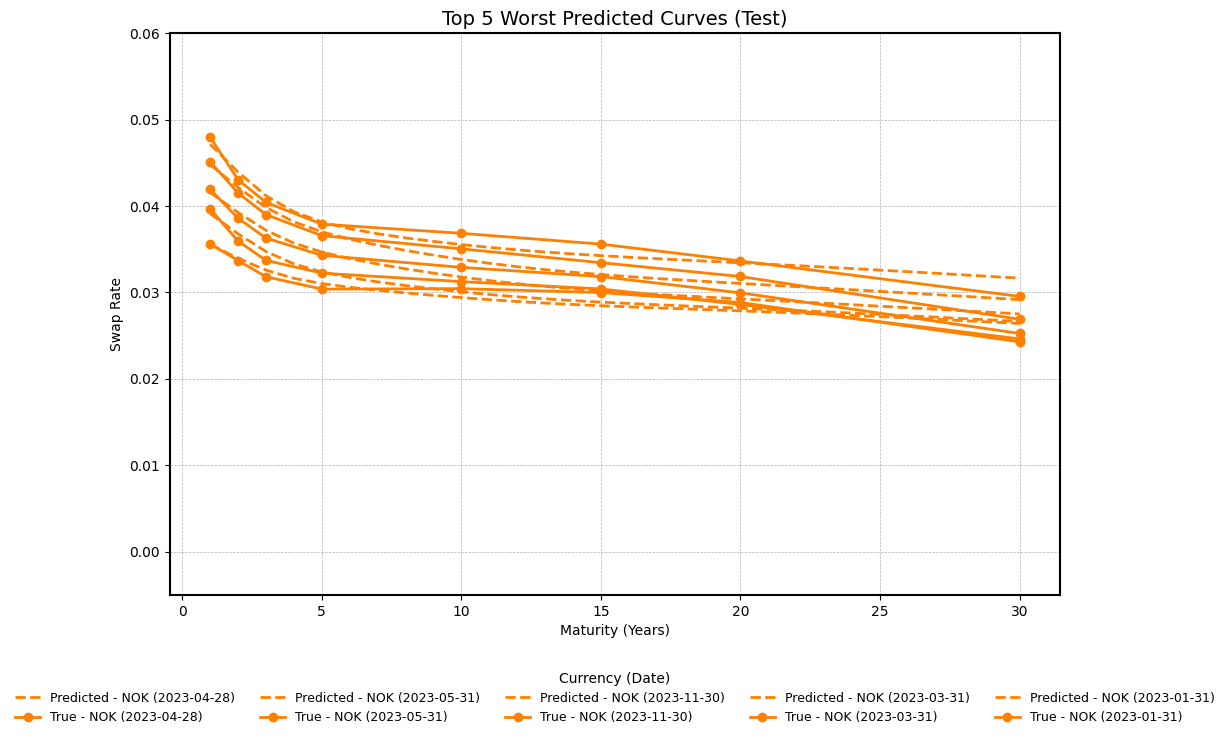

In [10]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- Prepare test data ---
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()
test_tensor = torch.tensor(test_df.iloc[:, 2:].values, dtype=torch.float32)
test_currencies = test_df["Currency"].values
test_dates = test_df["Date"].values

# --- Setup ---
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}
fallback_color = "#000000"

# --- Model Prediction ---
model.eval()
with torch.no_grad():
    zero_coupon_pred, _, maturities = model(test_tensor)
    swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_pred, maturities)
    selected_pred = swap_rates_pred[:, selected_indices]
    rmse_per_curve = torch.sqrt(torch.mean((selected_pred - test_tensor) ** 2, dim=1))

# --- Top 5 worst curves ---
worst_indices = torch.topk(rmse_per_curve, 5).indices.cpu().numpy()

# --- Plot ---
plt.figure(figsize=(12, 8))

for idx in worst_indices:
    currency = test_currencies[idx]
    date = pd.to_datetime(test_dates[idx]).strftime('%Y-%m-%d')
    color = custom_palette.get(currency, fallback_color)
    label = f"{currency} ({date})"

    true_curve = test_tensor[idx].numpy()
    pred_curve = swap_rates_pred[idx].cpu().numpy()

    plt.plot(full_maturities, pred_curve, linestyle="--", linewidth=2, color=color, label=f"Predicted - {label}")
    plt.plot(selected_maturities, true_curve, marker='o', linewidth=2, color=color, label=f"True - {label}")

# --- Formatting ---
plt.title("Top 5 Worst Predicted Curves (Test)", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(range(0, 31, 5))
plt.yticks(np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)
plt.grid(True, linestyle="--", linewidth=0.5)

for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

# --- Legend below plot ---
plt.legend(
    title="Currency (Date)",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=5,
    frameon=False,
    fontsize=9,
    title_fontsize=10
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

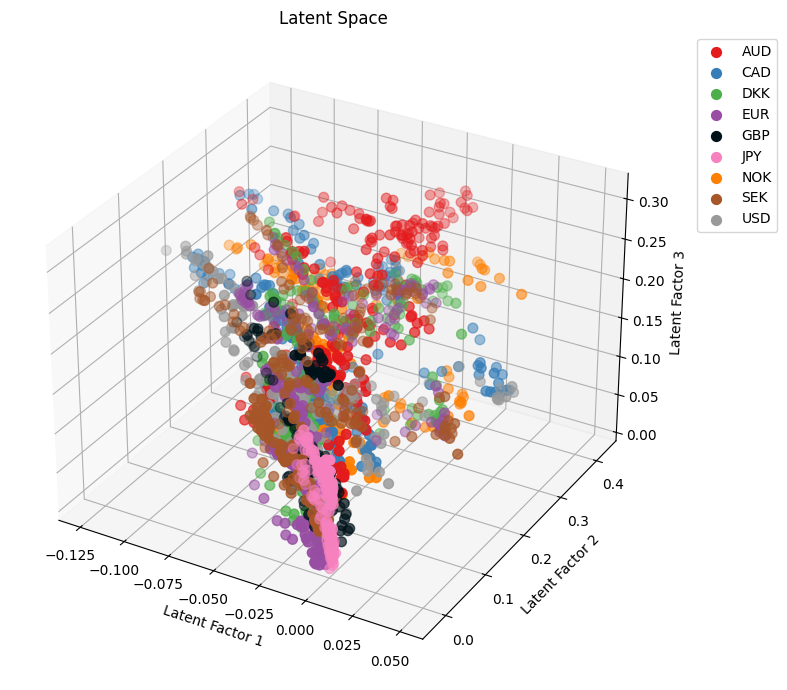

In [30]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Load your data
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']

# Prepare tensors
data_tensor = torch.tensor(data_full[maturity_cols].values, dtype=torch.float32)
currencies = data_full["Currency"].values

# Define custom currency color palette
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# Load model
#checkpoint = torch.load("best_autoencoder_model.pth")
#model = Autoencoder(
#    latent_dim=checkpoint["latent_dim"],
#    hidden_dim=checkpoint["hidden_dim"]
#)
#model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Run model
zero_coupon_rates, z, maturities = model(data_tensor)

# Prepare DataFrame
latent_dim = z.shape[1]
latent_df = pd.DataFrame(z.detach().numpy(), columns=[f"Latent_{i+1}" for i in range(latent_dim)])
latent_df["Currency"] = currencies

# Plotting
if latent_dim == 2:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=latent_df, x="Latent_1", y="Latent_2",
        hue="Currency", palette=custom_palette, s=70
    )
    plt.title("Latent Space (2D)")
    plt.xlabel("Latent Factor 1")
    plt.ylabel("Latent Factor 2")
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

elif latent_dim == 3:
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    #ax.view_init(elev=60, azim=60)
    for currency in latent_df["Currency"].unique():
        subset = latent_df[latent_df["Currency"] == currency]
        ax.scatter(
            subset["Latent_1"], subset["Latent_2"], subset["Latent_3"],
            label=currency, color=custom_palette.get(currency, "#000000"), s=50
        )
    ax.set_title("Latent Space")
    ax.set_xlabel("Latent Factor 1")
    ax.set_ylabel("Latent Factor 2")
    ax.set_zlabel("Latent Factor 3")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

else:
    print(f"Latent dimension {latent_dim} not supported for plotting.")


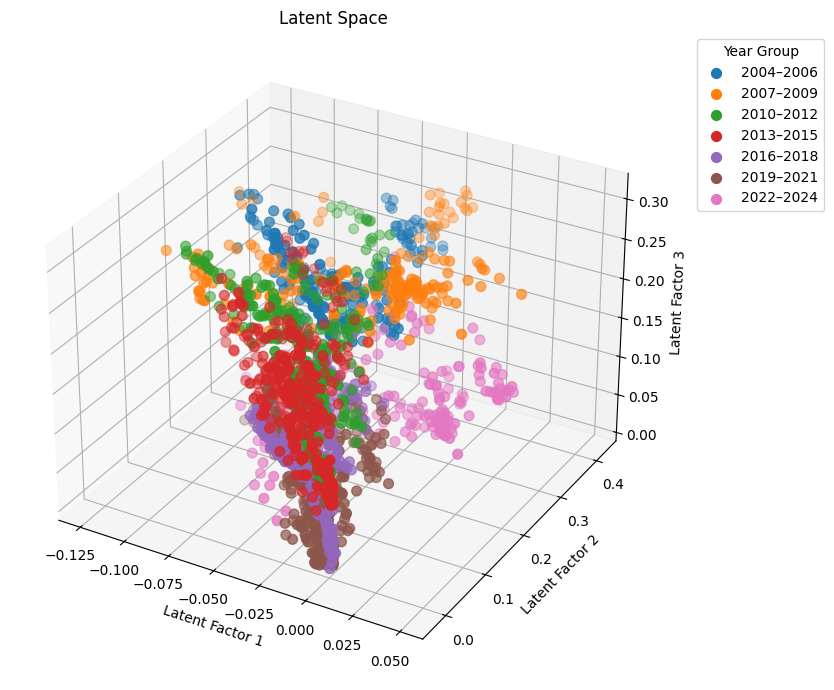

In [33]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Load your data
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year

# Filter to relevant year range
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# Create 3-year grouping like "2004–2006"
def label_year_group(year):
    base = (year - 2004) // 3 * 3 + 2004
    return f"{base}–{base+2}"

data_filtered["YearGroup"] = data_filtered["Year"].apply(label_year_group)

# Prepare input tensor
data_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
year_groups = data_filtered["YearGroup"].values

# Run model
model.eval()
zero_coupon_rates, z, maturities = model(data_tensor)

# Prepare DataFrame for plotting
latent_dim = z.shape[1]
latent_df = pd.DataFrame(z.detach().numpy(), columns=[f"Latent_{i+1}" for i in range(latent_dim)])
latent_df["YearGroup"] = year_groups

# Generate consistent color palette
year_group_order = sorted(latent_df["YearGroup"].unique())
palette = sns.color_palette("tab10", n_colors=len(year_group_order))
year_palette = {grp: col for grp, col in zip(year_group_order, palette)}

# Plotting
if latent_dim == 2:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=latent_df, x="Latent_1", y="Latent_2",
        hue="YearGroup", palette=year_palette, hue_order=year_group_order, s=70
    )
    plt.title("Latent Space Grouped by 3-Year Periods (2D)")
    plt.xlabel("Latent Factor 1")
    plt.ylabel("Latent Factor 2")
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Year Group")
    plt.tight_layout()
    plt.show()

elif latent_dim == 3:
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    #ax.view_init(elev=30, azim=45)
    for group in year_group_order:
        subset = latent_df[latent_df["YearGroup"] == group]
        ax.scatter(
            subset["Latent_1"], subset["Latent_2"], subset["Latent_3"],
            label=group, color=year_palette[group], s=50
        )
    ax.set_title("Latent Space")
    ax.set_xlabel("Latent Factor 1")
    ax.set_ylabel("Latent Factor 2")
    ax.set_zlabel("Latent Factor 3")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Year Group")
    plt.tight_layout()
    plt.show()

else:
    print(f"Latent dimension {latent_dim} not supported for plotting.")